In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import torch
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [4]:
import data
import models
import paths
import routine
import viz_tools

# Data

In [5]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

LA5 absmax before normalization: 435.0126647949219
Dataset size: 150
Labels distribution: (array([0, 1]), array([122,  28]))

Example:
Image shape: (1, 153, 189, 163)
Target: 0


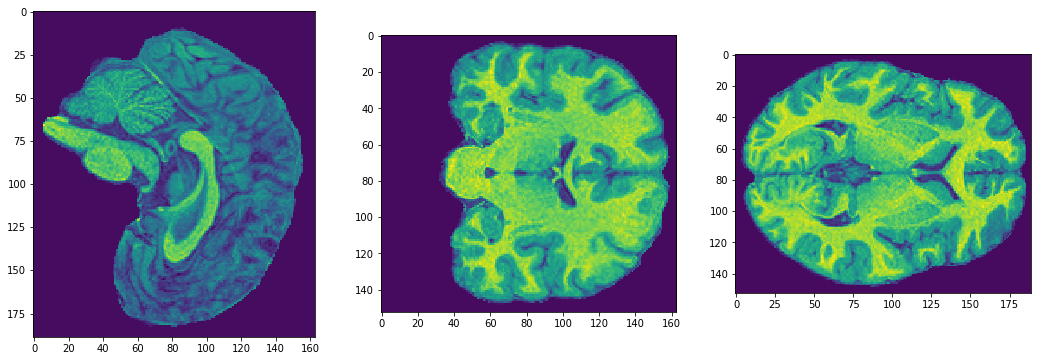

In [6]:
la5_dataset = data.LA5_Siblings_MRI(
    paths=paths.la5_data,
    target_path=paths.la5_target_path,
    load_online=True,
    mri_type="sMRI",
    mri_file_suffix=paths.la5_smri_file_suffix,
    brain_mask_suffix=paths.la5_smri_brain_mask_suffix,
    coord_min=(20,20,0),
    img_shape=(153, 189, 163),
    problems=['Schz/Control'],
    temp_storage_path=paths.la5_temp_npy_folder_path
)
la5_absmax = 435.0126647949219 # get_absmax(la5_dataset)
la5_dataset.transform = functools.partial(AbsMaxScale, absmax=la5_absmax)
print("LA5 absmax before normalization: {}".format(la5_absmax))
print("Dataset size: {}".format(len(la5_dataset)))
print("Labels distribution: {}\n".format(np.unique(la5_dataset.labels, return_counts=True)))

print("Example:")
img, target = la5_dataset[0]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
viz_tools.plot_central_cuts(img)

Siblings absmax before normalization: 730.7531127929688
Dataset size: 64
Labels distribution: (array([0, 1]), array([41, 23]))

Example:
Image shape: (1, 153, 189, 163)
Target: 1


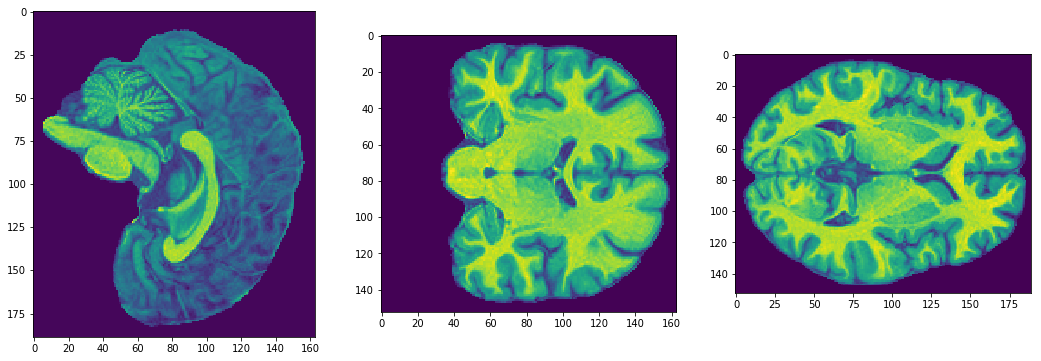

In [7]:
sibl_dataset = data.LA5_Siblings_MRI(
    paths=paths.sibl_data,
    target_path=paths.sibl_target_path,
    load_online=True,
    mri_type="sMRI",
    mri_file_suffix=paths.sibl_smri_file_suffix,
    brain_mask_suffix=paths.sibl_smri_brain_mask_suffix,
    coord_min=(20,20,0),
    img_shape=(153, 189, 163),
    problems=['Schz/Control'],
    temp_storage_path=paths.sibl_temp_npy_folder_path,
)
sibl_absmax = 730.7531127929688 # get_absmax(sibl_dataset)
sibl_dataset.transform = functools.partial(AbsMaxScale, absmax=sibl_absmax)
print("Siblings absmax before normalization: {}".format(sibl_absmax))
print("Dataset size: {}".format(len(sibl_dataset)))
print("Labels distribution: {}\n".format(np.unique(sibl_dataset.labels, return_counts=True)))

print("Example:")
img, target = sibl_dataset[0]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
viz_tools.plot_central_cuts(img)

# Model structure

In [8]:
def create_model_opt(model_load_path=None, transfer=False):
    # reproducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    model = models.VoxResNet(num_classes=2, n_filters=32, stride=2, n_blocks=4,
                             input_shape=la5_dataset.img_shape, dropout=0., n_fc_units=128,
                             n_flatten_units=23040)
    
    if model_load_path is not None:
        model.load_state_dict(torch.load(model_load_path))  
    if transfer:
        for param in model.parameters():
            param.requires_grad = False
        
        last = torch.nn.Linear(128, 2)
        modules = list(list(model.children())[0].children())[:-1] + [last]
        model = torch.nn.Sequential(torch.nn.Sequential(*modules))
        
        opt = torch.optim.Adam(last.parameters(), lr=3e-5)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=3e-5)
    return model, opt

# Train - LA5, Test - LA5

Epoch 10 of 100 took 66.168s
  training loss (in-iteration): 	0.002508
  validation loss: 			0.429337
  training roc_auc_score: 			1.00
  validation roc_auc_score: 			0.88


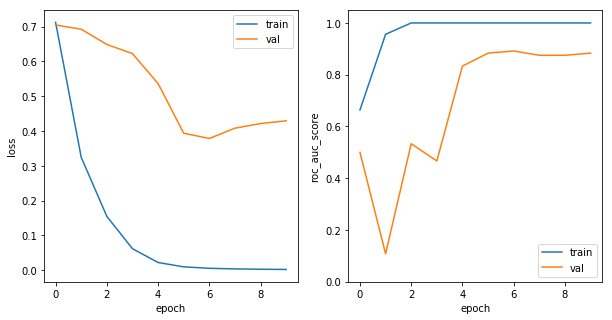

<Figure size 720x360 with 0 Axes>

Early stopping! Train loss < eps.
val roc_auc_scores: [0.8066666666666666, 0.8200000000000001, 0.7291666666666667, 0.75, 0.8916666666666667]
val roc_auc_score mean: 0.7995
val roc_auc_score std: 0.057207225650844726
CPU times: user 30min 26s, sys: 17min 46s, total: 48min 13s
Wall time: 30min 54s


In [9]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, la5_dataset, cv, device, metric, batch_size=10)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

# Train - Siblings, Test - Siblings

Epoch 11 of 100 took 31.503s
  training loss (in-iteration): 	0.002986
  validation loss: 			0.753494
  training roc_auc_score: 			1.00
  validation roc_auc_score: 			0.56


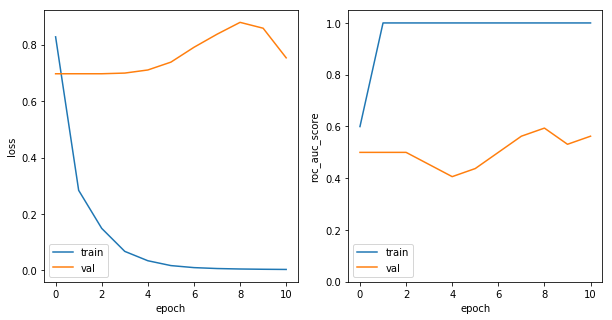

<Figure size 720x360 with 0 Axes>

Early stopping! Train loss < eps.
val roc_auc_scores: [0.6333333333333334, 0.725, 0.775, 0.96875, 0.59375]
val roc_auc_score mean: 0.7391666666666666
val roc_auc_score std: 0.13155981951610873
CPU times: user 18min 13s, sys: 10min 15s, total: 28min 29s
Wall time: 33min 51s


In [10]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, sibl_dataset, cv, device, metric, batch_size=10)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

# Pretrain model on LA5 and save

In [9]:
model_save_path = "./models/conv_pretrained_la5.pth"

Epoch 7 of 100 took 43.135s
  training loss (in-iteration): 	0.002165
  training roc_auc_score: 			1.00


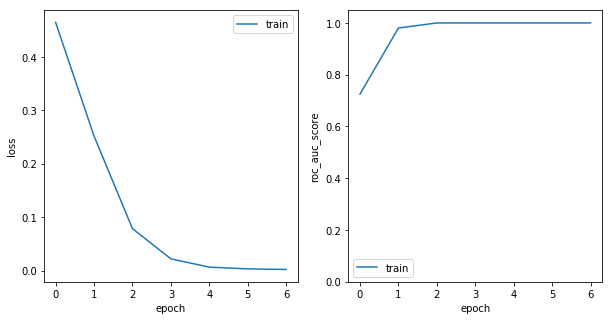

<Figure size 720x360 with 0 Axes>

Early stopping! Train loss < eps.
CPU times: user 5min 23s, sys: 3min 14s, total: 8min 38s
Wall time: 7min 16s


In [10]:
%%time
model, optimizer = create_model_opt()
metric = roc_auc_score
train_idx = np.arange(len(la5_dataset))
np.random.seed(0)
np.random.shuffle(train_idx)
train_idx = routine.stratified_batch_indices(train_idx, la5_dataset.labels[train_idx])
train_loader = DataLoader(Subset(la5_dataset, train_idx),
                          shuffle=False,
                          batch_size=10,
                          drop_last=False)
_ = routine.train(model, optimizer, train_loader, None, device, metric, verbose=1,
                  model_save_path=model_save_path)
del model, optimizer, train_loader

# Pretrain - LA5, Test - Siblings

In [10]:
%%time
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, sibl_dataset, cv, device, metric,
                                      model_load_path=model_save_path)

print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

100%|██████████| 2/2 [00:02<00:00,  1.00s/it]

val roc_auc_scores: [0.7]
val roc_auc_score mean: 0.7
val roc_auc_score std: 0.0
CPU times: user 5.96 s, sys: 3.15 s, total: 9.12 s
Wall time: 6.32 s


# Pretrain - LA5, Train/Test - Siblings (fine tuning)

Epoch 9 of 100 took 16.872s
  training loss (in-iteration): 	0.002565
  validation loss: 			0.594996
  training roc_auc_score: 			1.00
  validation roc_auc_score: 			0.70


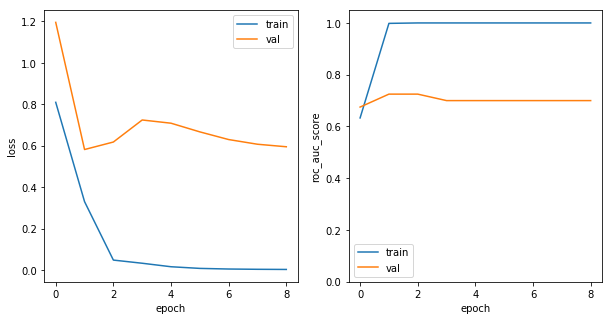

<Figure size 720x360 with 0 Axes>

Early stopping! Train loss < eps.
val roc_auc_scores: [0.7250000000000001]
val roc_auc_score mean: 0.7250000000000001
val roc_auc_score std: 0.0
CPU times: user 2min 55s, sys: 1min 41s, total: 4min 37s
Wall time: 3min 2s


In [11]:
%%time
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, sibl_dataset, cv, device, metric,
                                      model_load_path=model_save_path, finetune=True)

print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

# Pretrain - LA5, Train/Test - Siblings (transfer learning)

Epoch 12 of 100 took 9.339s
  training loss (in-iteration): 	0.758722
  validation loss: 			0.788217
  training roc_auc_score: 			0.39
  validation roc_auc_score: 			0.33


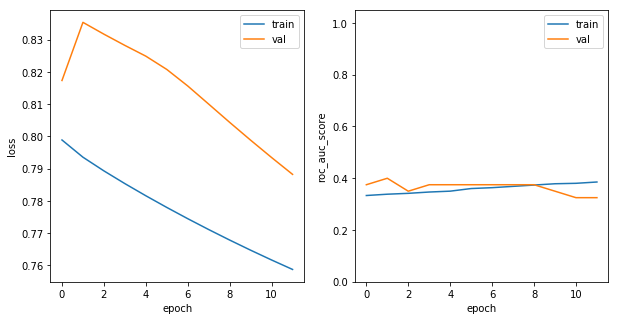

<Figure size 720x360 with 0 Axes>

Early stopping! Patience is out.
val roc_auc_scores: [0.4]
val roc_auc_score mean: 0.4
val roc_auc_score std: 0.0
CPU times: user 3min, sys: 1min 42s, total: 4min 43s
Wall time: 2min 1s


In [10]:
%%time
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, sibl_dataset, cv, device, metric,
                                      model_load_path=model_save_path, transfer=True)

print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

# Conclusion